### Building a reference atlas cross-species

In this notebook, we will build a reference atlas for the motor cortex by combining three species (mouse, marmoset, and human). We will reproduce Figure 4 and Figure S17, S18. The count data and latent spaces can be downloaded from [Zenodo](https://doi.org/10.5281/zenodo.6786357).

**NOTE** The count data for these datasets is quite big, so to training the models yourself might take some time & memory.

In [1]:
import scanpy as sc
import pandas as pd

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import gdown
import seaborn as sns

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(6, 6))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)


Global seed set to 0


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("[*] Selected device: ", device)


[*] Selected device:  cuda


### Read count data

In [3]:
M1_data = sc.read_h5ad('M1_counts.h5ad')
M1_data

AnnData object with n_obs × n_vars = 305638 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: '_index', 'features'

In [4]:
M1_data.X

<305638x15680 sparse matrix of type '<class 'numpy.float64'>'
	with 1132418344 stored elements in Compressed Sparse Row format>

#### Split in reference and query dataset

In [5]:
target_species = ['human']

In [6]:
source_adata = M1_data[~M1_data.obs.species.isin(target_species)].copy()
target_adata = M1_data[M1_data.obs.species.isin(target_species)].copy()
print(source_adata)
print(target_adata)


AnnData object with n_obs × n_vars = 229017 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: '_index', 'features'
AnnData object with n_obs × n_vars = 76621 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: '_index', 'features'


In [7]:
### Delete complete data to free some space
del M1_data

#### Preprocess the data

In [8]:
source_adata.raw = source_adata
source_adata

AnnData object with n_obs × n_vars = 229017 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: '_index', 'features'

In [9]:
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [10]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="species",
    subset=True)


In [11]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### Create scVI model & train on reference dataset

In [13]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="species")


In [14]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)


In [15]:
vae.train(max_epochs=500)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [4:05:29<00:00, 29.46s/it, loss=956, v_num=1]


### Visualize the latent space

In [23]:
## Load the latent space if you didn't train it yourself

ref_latent = sc.AnnData(vae.get_latent_representation())
# ref_latent = sc.read('ref_latent.h5ad')
ref_latent.obs["species"] = source_adata.obs["species"].tolist()
ref_latent.obs["Class"] = source_adata.obs["Class"].tolist()
ref_latent.obs["Subclass"] = source_adata.obs["Subclass"].tolist()
ref_latent.obs["Subclass_toplot"] = source_adata.obs["Subclass"].tolist()
ref_latent.obs["RNA_cluster"] = source_adata.obs["RNA_cluster"].tolist()
ref_latent.obs["Cross_species"] = source_adata.obs["Cross_species"].tolist()


In [24]:
sc.pp.neighbors(ref_latent, n_neighbors=8)
sc.tl.leiden(ref_latent)
sc.tl.umap(ref_latent)


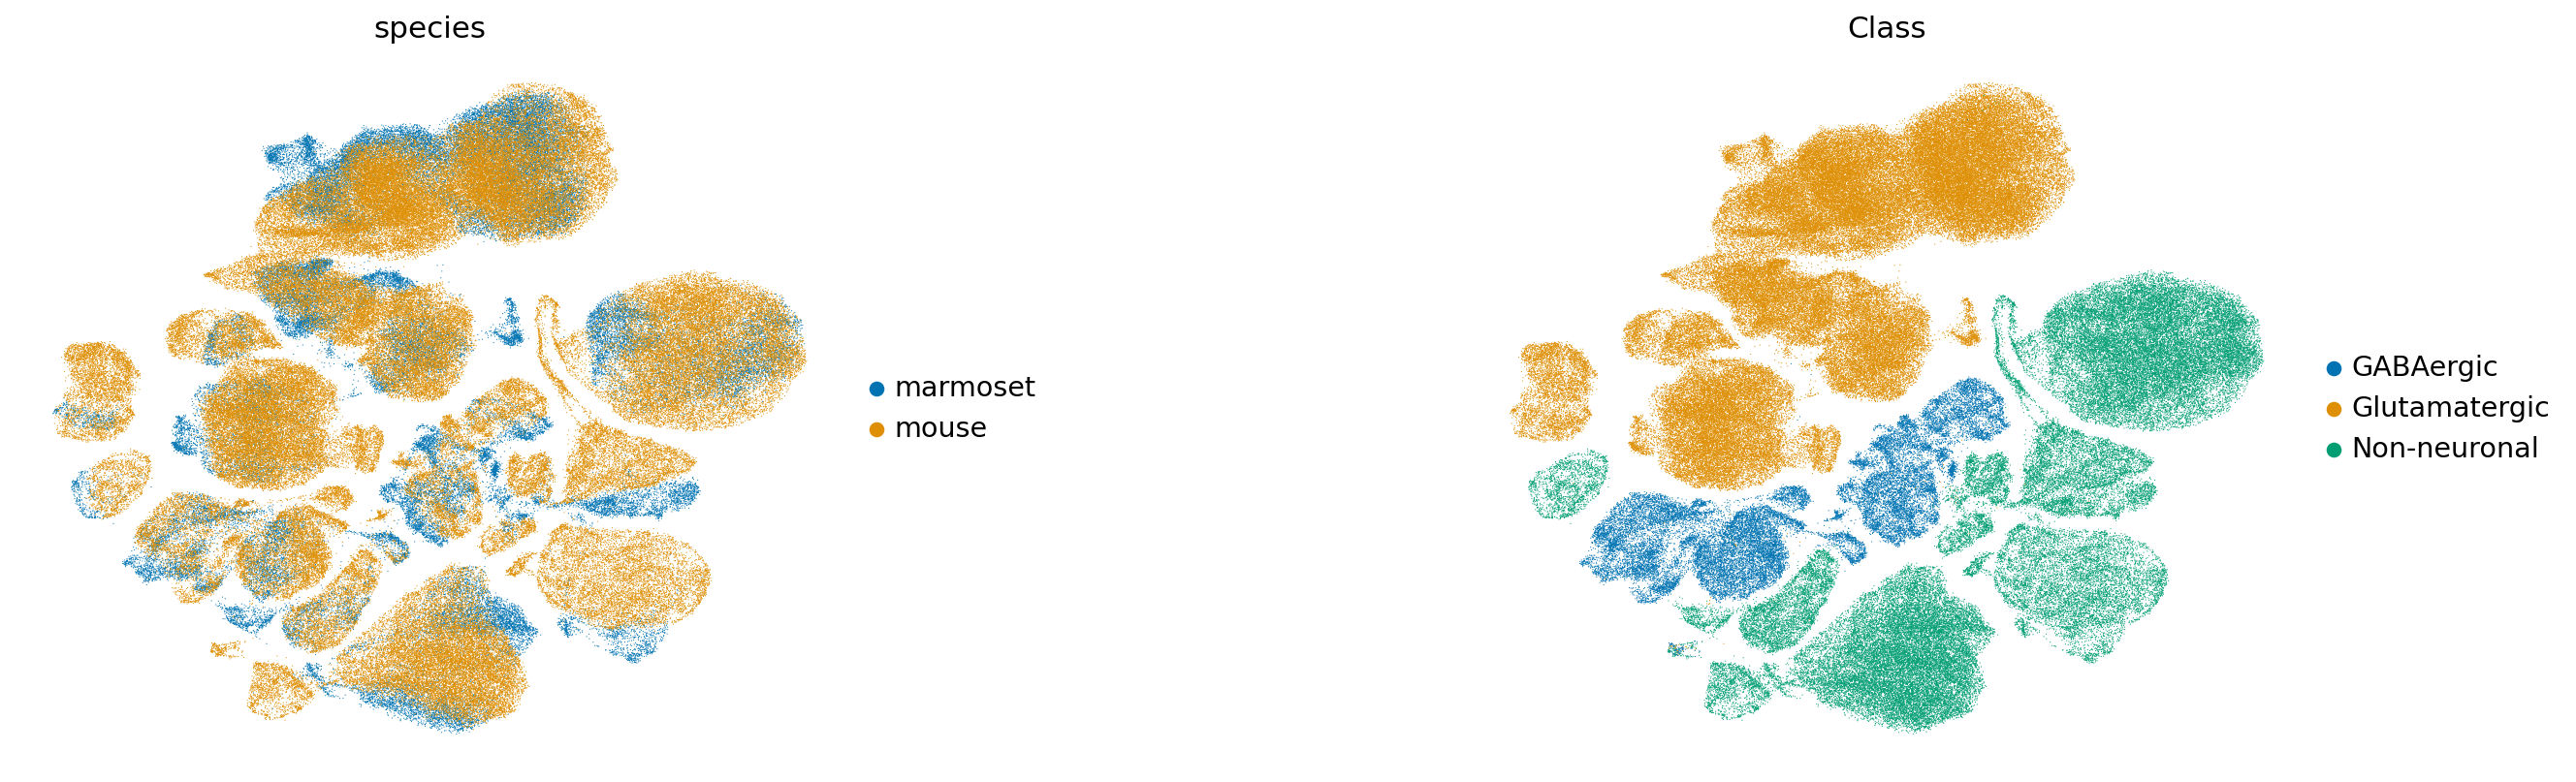

In [25]:
sc.pl.umap(ref_latent,
           color=['species', 'Class'],
           frameon=False,
           wspace=0.6,
           s=1, palette=sns.color_palette('colorblind', as_cmap=True),
           )


Next, we want to color the plot according to subclass, but only show the GABAergic subclasses.

So we rename all other subclasses to 'Astro' and plot those in grey.

In [26]:
idx = np.where(ref_latent.obs['Class'] != 'GABAergic')[0]
ref_latent.obs['Subclass_toplot'].values[idx] = 'Astro'
ref_latent.obs['Subclass_toplot'].cat.remove_unused_categories(inplace=True)
ref_latent.obs['Subclass_toplot'].cat.reorder_categories(['Lamp5', 'Meis2', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'Vip', 'Astro'], inplace=True)


Fix the colormap

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)


COL = MplColorHelper('Accent', 0, 6)

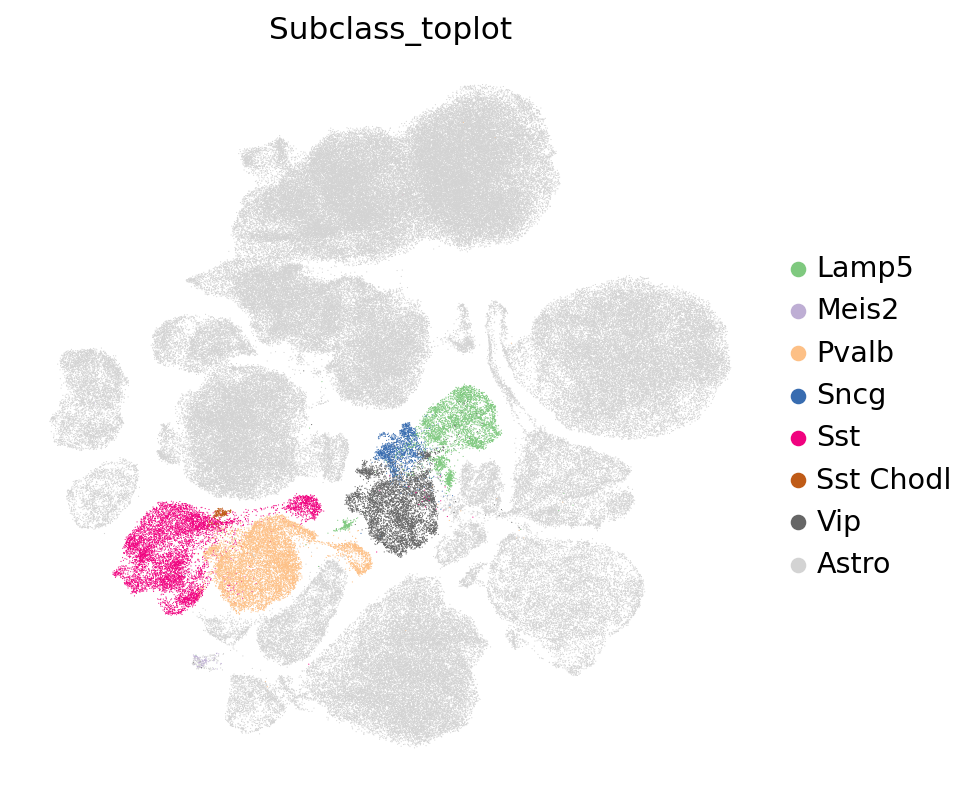

In [28]:
sc.pl.umap(ref_latent,
           color=['Subclass_toplot'], 
           s=1,
           frameon=False,
           wspace=0.6, 
           palette=[COL.get_rgb(0), 
                    COL.get_rgb(1),
                    COL.get_rgb(2),
                    COL.get_rgb(3),
                    COL.get_rgb(4),
                    COL.get_rgb(5),
                    COL.get_rgb(6), 
                    'lightgrey']
           )


Save the model and latent space for later use

In [29]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)
ref_latent.write(ref_path + 'ref_latent.h5ad')

### Construct hierarchy for reference using scHPL

Again, we concatenate the subclass & species label to make the cell type labels unique

In [30]:
ref_latent.obs['subclass_batch'] = np.char.add(np.char.add(np.array(ref_latent.obs['Subclass'], dtype= str), '-'),
                                             np.array(ref_latent.obs['species'], dtype=str))


Starting tree:


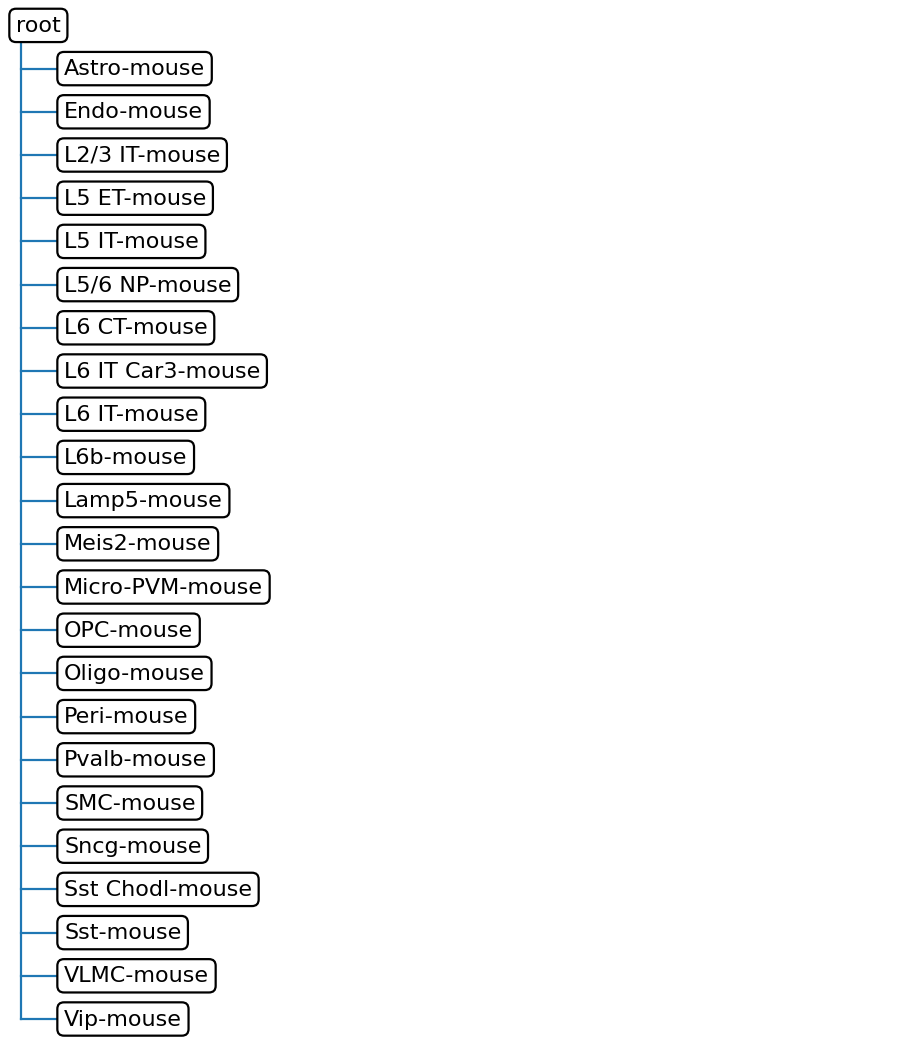


Adding dataset marmoset to the tree

Updated tree:


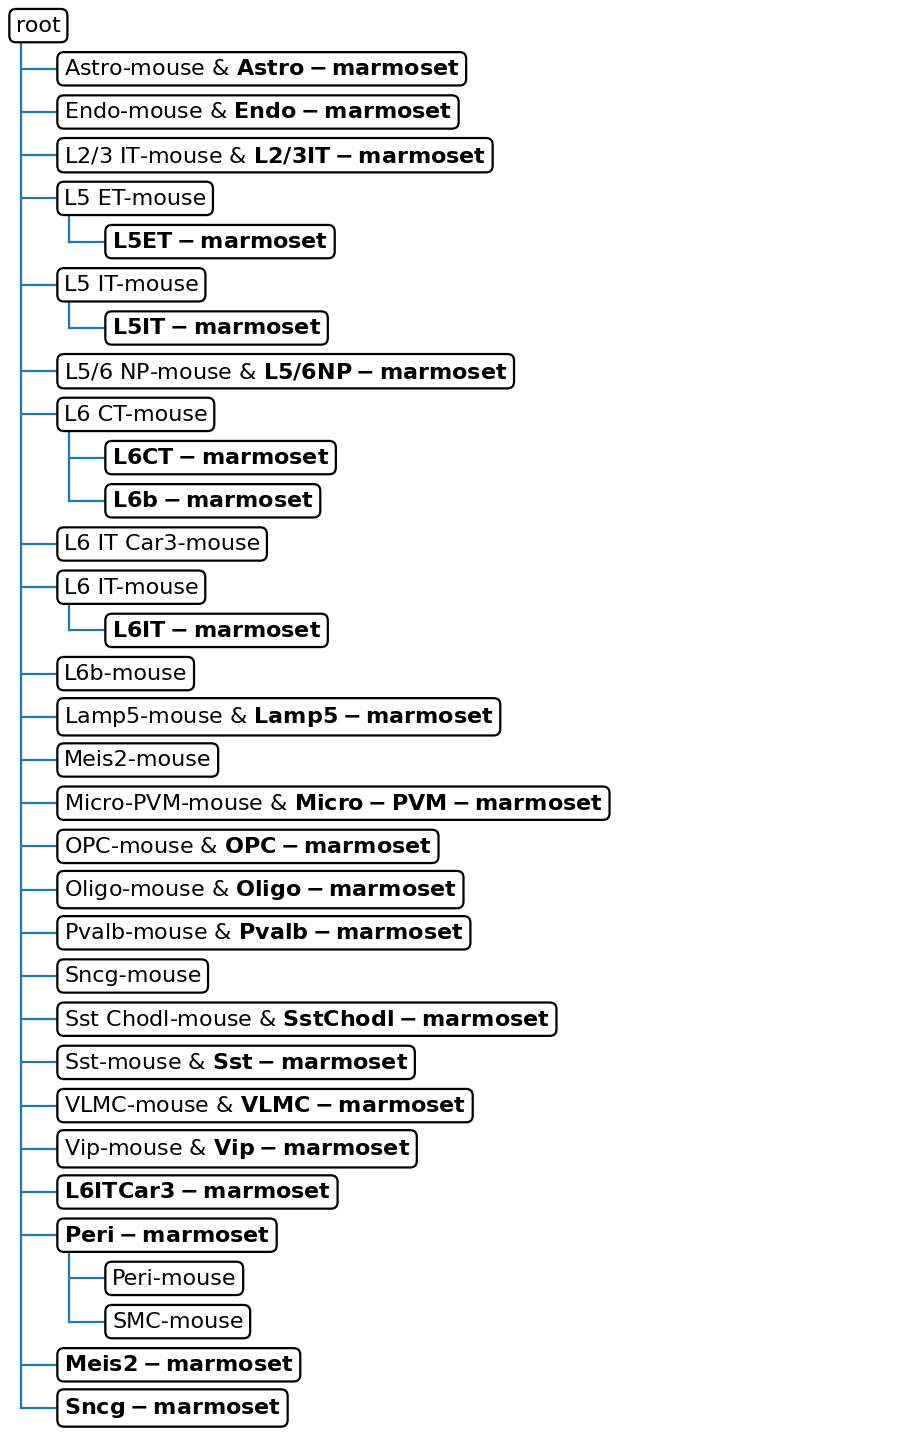

In [32]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = ref_latent, 
                batch_key = 'species',
                batch_order = ['mouse', 'marmoset'],
                cell_type_key='subclass_batch',
                classifier = 'knn')


#### Visualize the Meis2 populations & Sncg populations

The Meis2 and Sncg populations do not match, so we visualize their location in the UMAP and visualize the expression of marker genes.

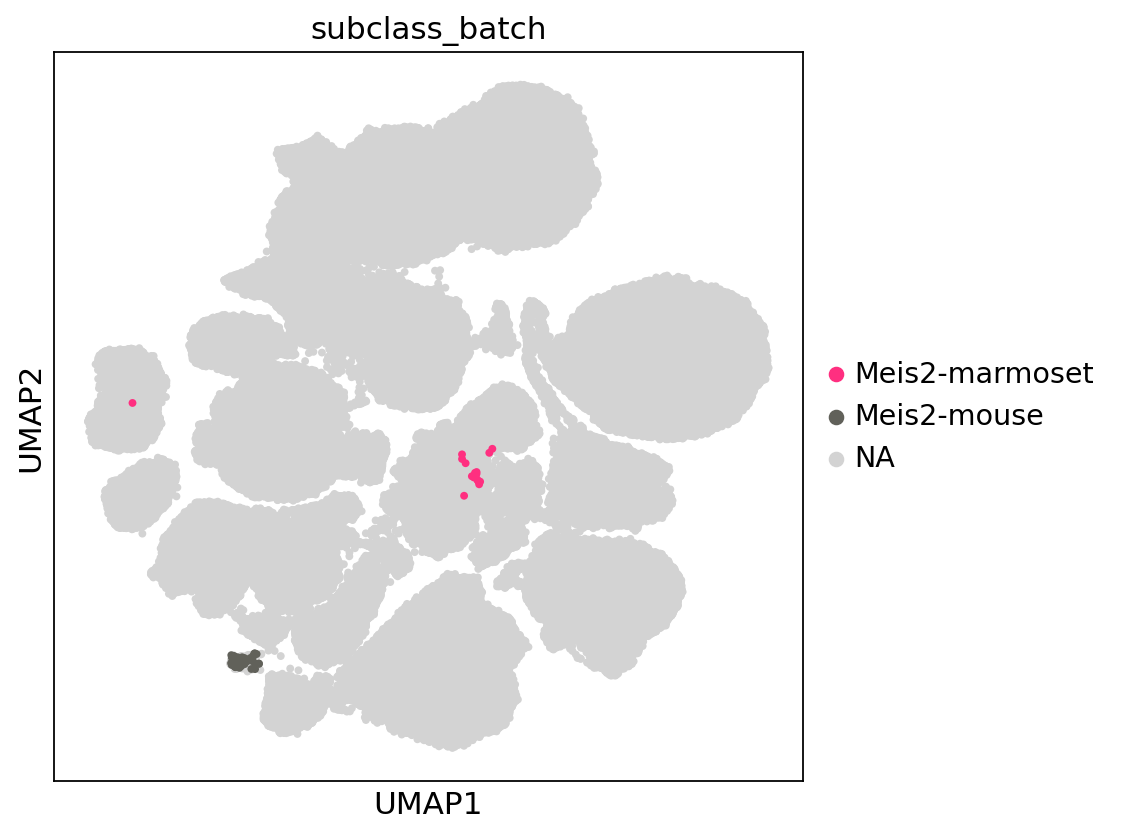

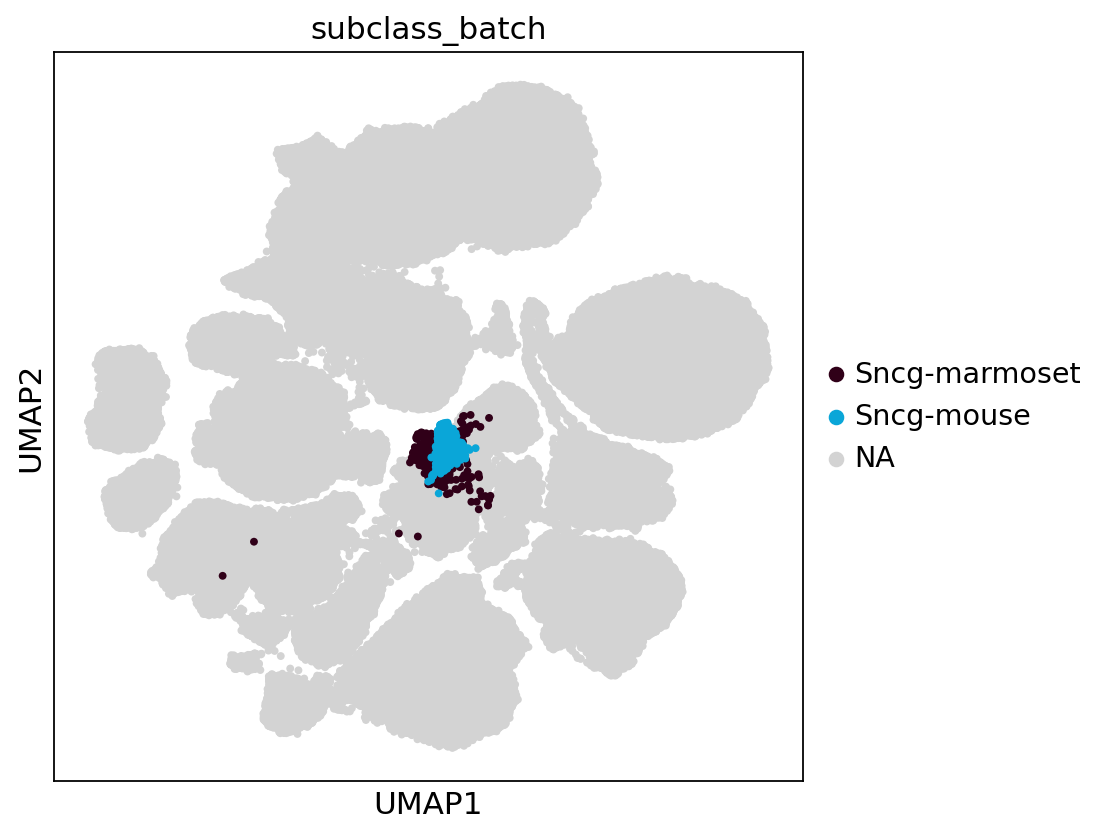

In [34]:
# ref_latent.obs['subclass_batch'] = np.char.add(np.char.add(np.array(ref_latent.obs['Subclass'], dtype= str), '-'),
#                                              np.array(ref_latent.obs['species'], dtype=str))

sc.pl.umap(ref_latent,
           color=['subclass_batch'], groups=['Meis2-mouse', 'Meis2-marmoset'],
           s=50, use_raw=False,
           frameon=True,
           wspace=0.6, save='Meis2_umap.pdf')

sc.pl.umap(ref_latent,
           color=['subclass_batch'], groups=['Sncg-mouse', 'Sncg-marmoset'],
           s=50, use_raw=False,
           frameon=True,
           wspace=0.6, save='Sncg_umap.pdf')


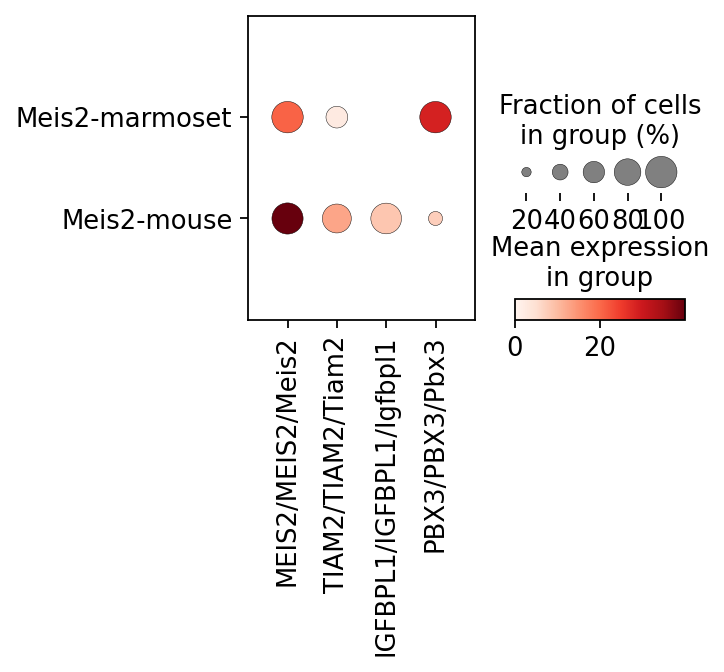

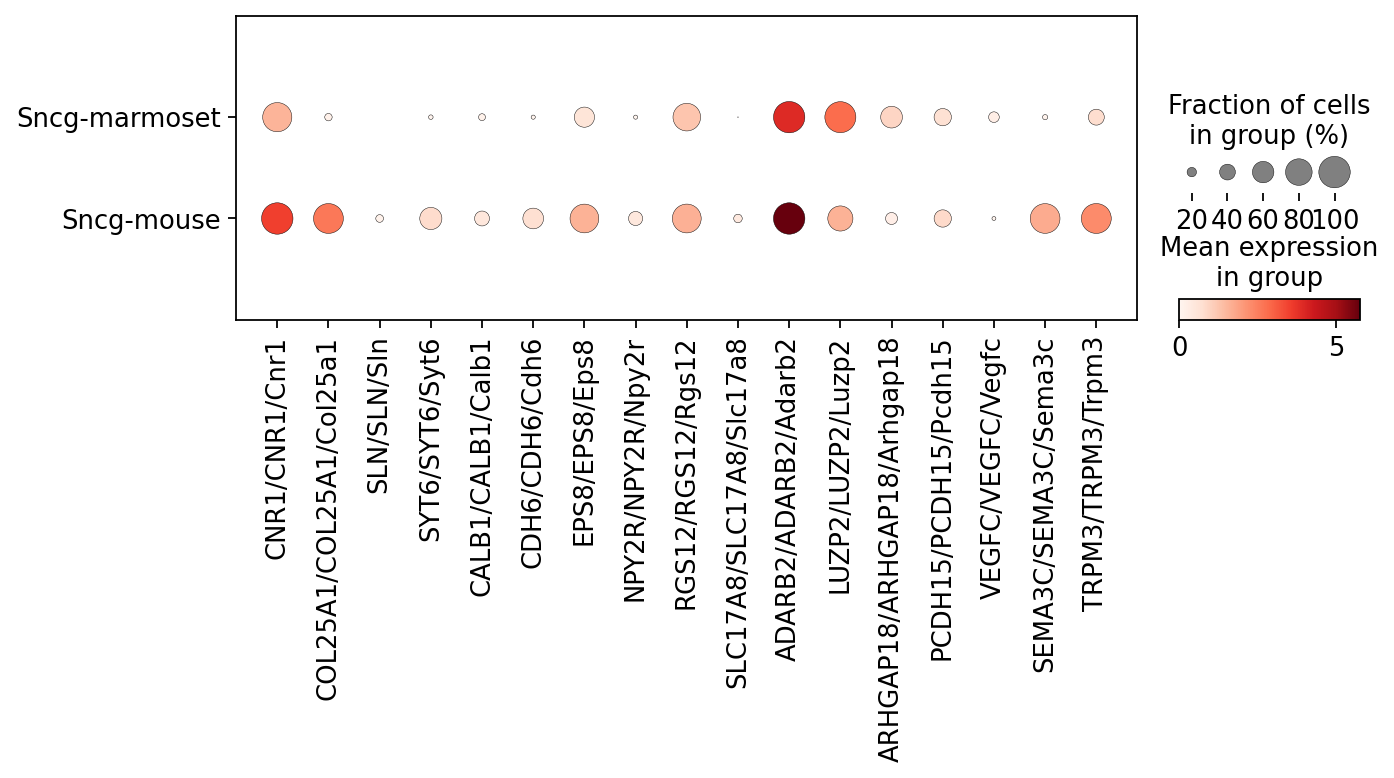

In [35]:
## Gene names are human/marmoset/mouse gene name.
source_adata.raw.var.index = source_adata.raw.var['_index']
source_adata.obs['subclass_batch'] = ref_latent.obs['subclass_batch'].values
  
source_adata_meis = source_adata[source_adata.obs.Subclass == 'Meis2']

sc.pl.dotplot(source_adata_meis,
              ['MEIS2/MEIS2/Meis2',
               'TIAM2/TIAM2/Tiam2',
               'IGFBPL1/IGFBPL1/Igfbpl1',
               'PBX3/PBX3/Pbx3'], 
              'subclass_batch',
              figsize=[3.5, 2.5],
              save='meis2_expr.pdf')

source_adata_sncg = source_adata[source_adata.obs.Subclass == 'Sncg']

sc.pl.dotplot(source_adata_sncg,
              ['CNR1/CNR1/Cnr1',
               'COL25A1/COL25A1/Col25a1', 
               'SLN/SLN/Sln',
               'SYT6/SYT6/Syt6',
               'CALB1/CALB1/Calb1',
               'CDH6/CDH6/Cdh6',
               'EPS8/EPS8/Eps8',
               'NPY2R/NPY2R/Npy2r',
               'RGS12/RGS12/Rgs12',
               'SLC17A8/SLC17A8/Slc17a8',
               'ADARB2/ADARB2/Adarb2',
               'LUZP2/LUZP2/Luzp2',
               'ARHGAP18/ARHGAP18/Arhgap18',
               'PCDH15/PCDH15/Pcdh15',
               'VEGFC/VEGFC/Vegfc',
               'SEMA3C/SEMA3C/Sema3c',
               'TRPM3/TRPM3/Trpm3'], 
              'subclass_batch', 
              figsize = [9,2.5],
              save='sncg_expr.pdf', log=True
             )

### Apply surgery with human dataset

In [36]:
target_adata = target_adata[:, source_adata.var_names]
target_adata


View of AnnData object with n_obs × n_vars = 76621 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: '_index', 'features'

In [37]:
target_adata = target_adata.copy()

In [38]:
ref_path = 'ref_model/'

model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)


INFO     File ref_model_M1/model.pt already downloaded                                       


In [39]:
model.train(max_epochs=100)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:04<00:00,  8.45s/it, loss=1.57e+03, v_num=1]


In [49]:
# query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs["species"] = target_adata.obs["species"].tolist()
query_latent.obs["Class"] = target_adata.obs["Class"].tolist()
query_latent.obs["Subclass"] = target_adata.obs["Subclass"].tolist()
query_latent.obs["Subclass_toplot"] = target_adata.obs["Subclass"].tolist()
query_latent.obs["RNA_cluster"] = target_adata.obs["RNA_cluster"].tolist()
query_latent.obs["Cross_species"] = target_adata.obs["Cross_species"].tolist()


In [50]:
full_latent = ref_latent.concatenate(query_latent,
                                     batch_key = 'ref_query')

In [88]:
## If you don't want to train the model, you can also load the latent space from zenodo
# full_latent = sc.read('full_latent.h5ad')

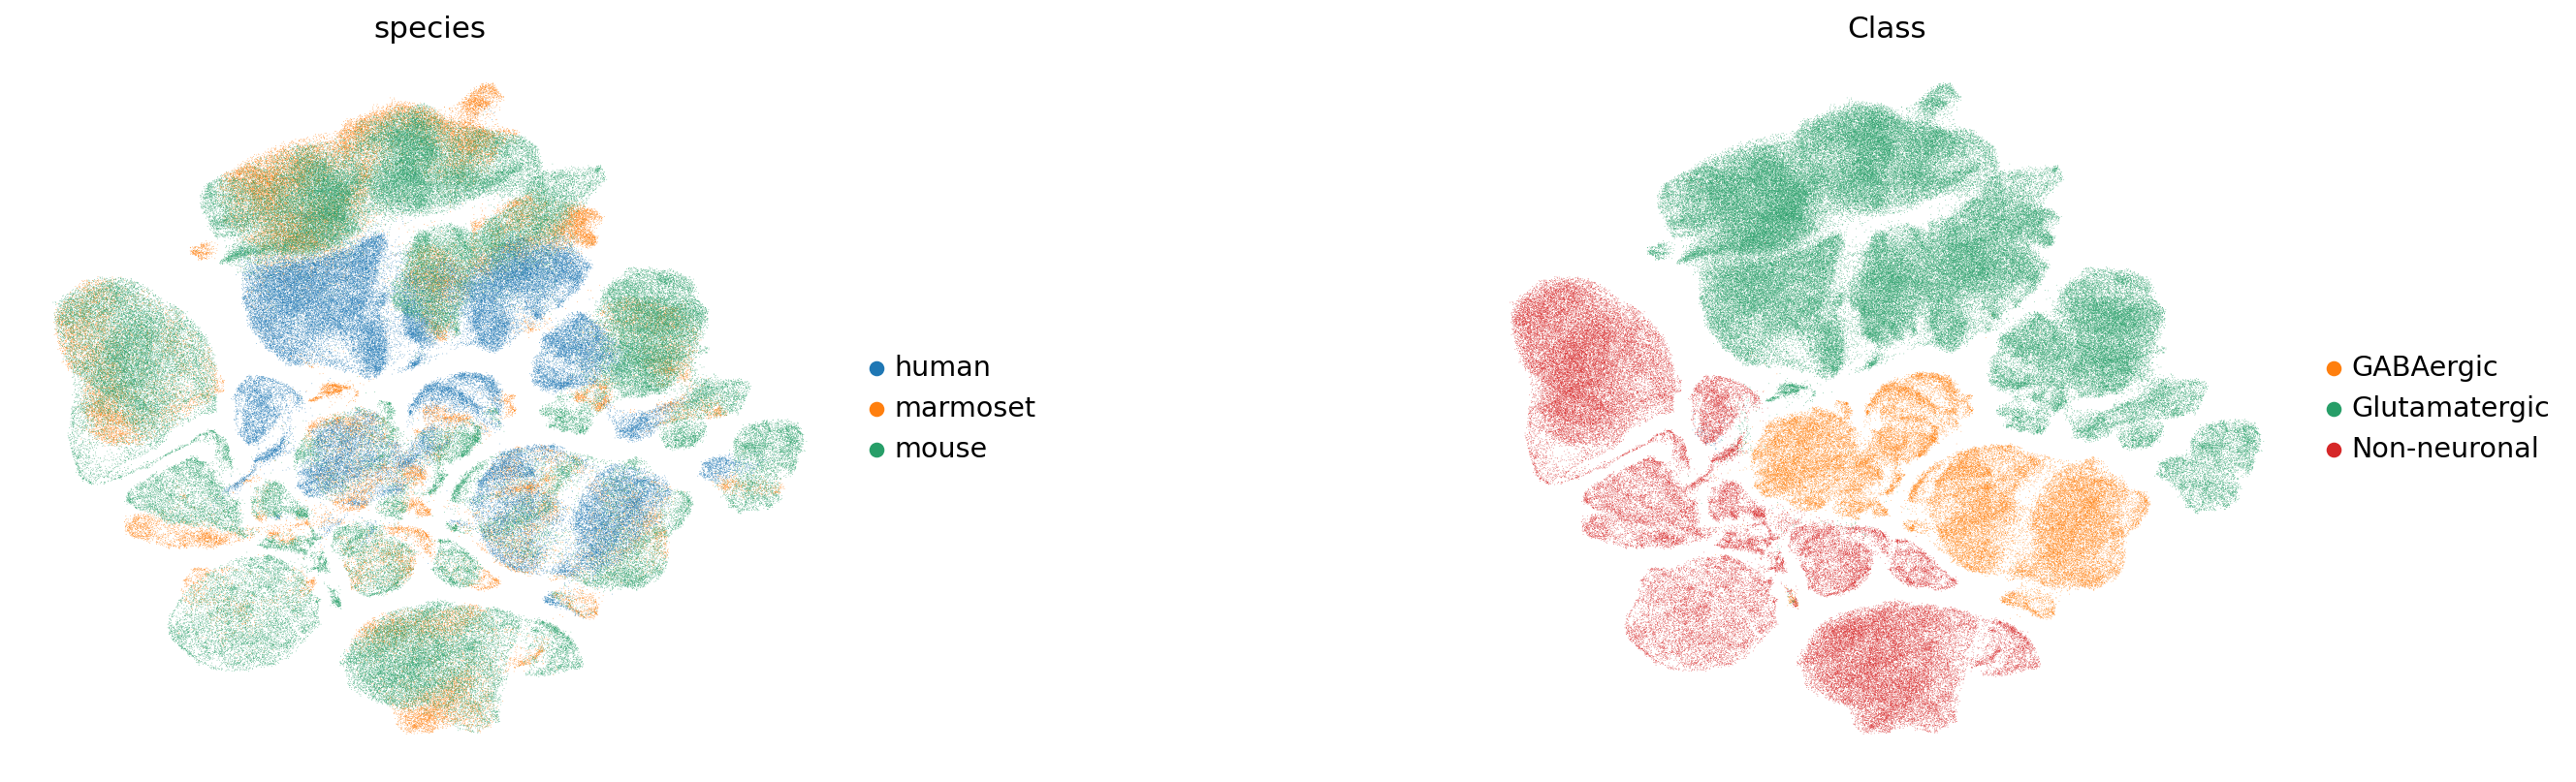

In [51]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['species', 'Class'],
           frameon=False,
           wspace=0.6,
           )


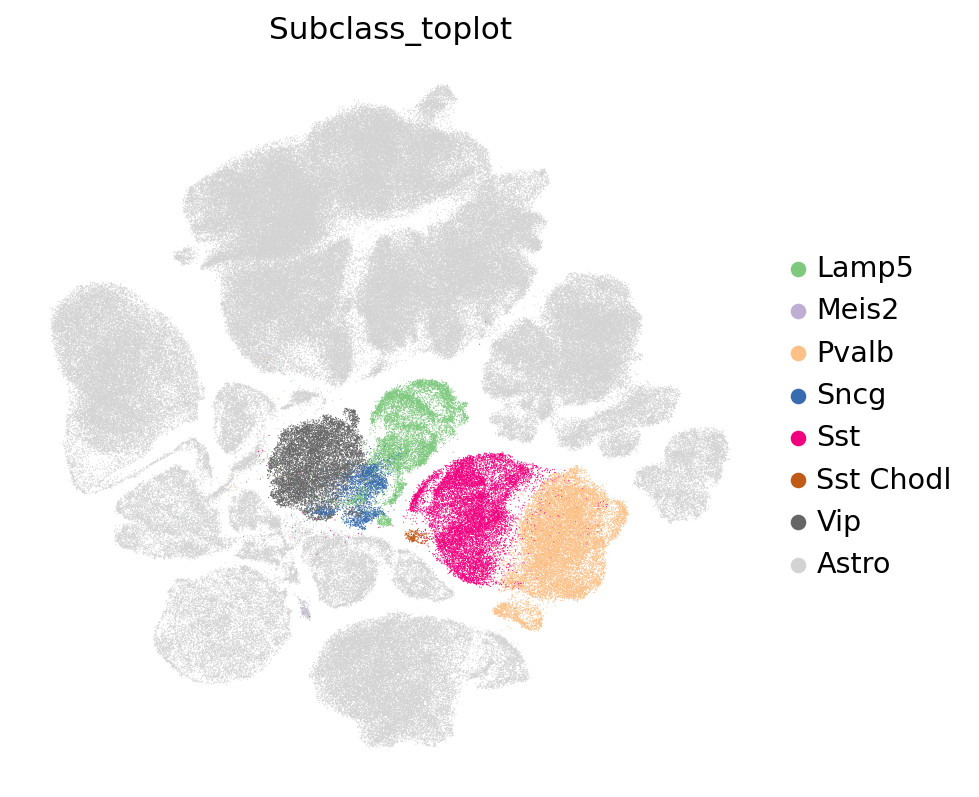

In [52]:
## For plotting the subclasses, we do the same trick as we did for the reference latent space
idx = np.where(full_latent.obs['Class'] != 'GABAergic')[0]
full_latent.obs['Subclass_toplot'].values[idx] = 'Astro'
full_latent.obs['Subclass_toplot'].cat.remove_unused_categories(inplace=True)
full_latent.obs['Subclass_toplot'].cat.reorder_categories(['Lamp5', 'Meis2', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'Vip', 'Astro'], inplace=True)

sc.pl.umap(full_latent,
           color=['Subclass_toplot'], 
           s=1,
           frameon=False,
           wspace=0.6, 
           palette=[COL.get_rgb(0), 
                    COL.get_rgb(1),
                    COL.get_rgb(2),
                    COL.get_rgb(3),
                    COL.get_rgb(4),
                    COL.get_rgb(5),
                    COL.get_rgb(6), 
                    'lightgrey']
           )


Again we can save the trained model + learned latent space.

In [53]:
surgery_path = 'surgery_model/'
model.save(surgery_path, overwrite=True)
full_latent.write(surgery_path + 'full_latent.h5ad')

### Update the hierarchy with the human dataset

In [54]:
full_latent.obs['subclass_batch'] = np.char.add(np.char.add(np.array(full_latent.obs['Subclass'], dtype= str), '-'),
                                             np.array(full_latent.obs['species'], dtype=str))


In [55]:
# Delete human cells without an annotation
full_latent = full_latent[full_latent.obs['subclass_batch'] != '-human']


Starting tree:


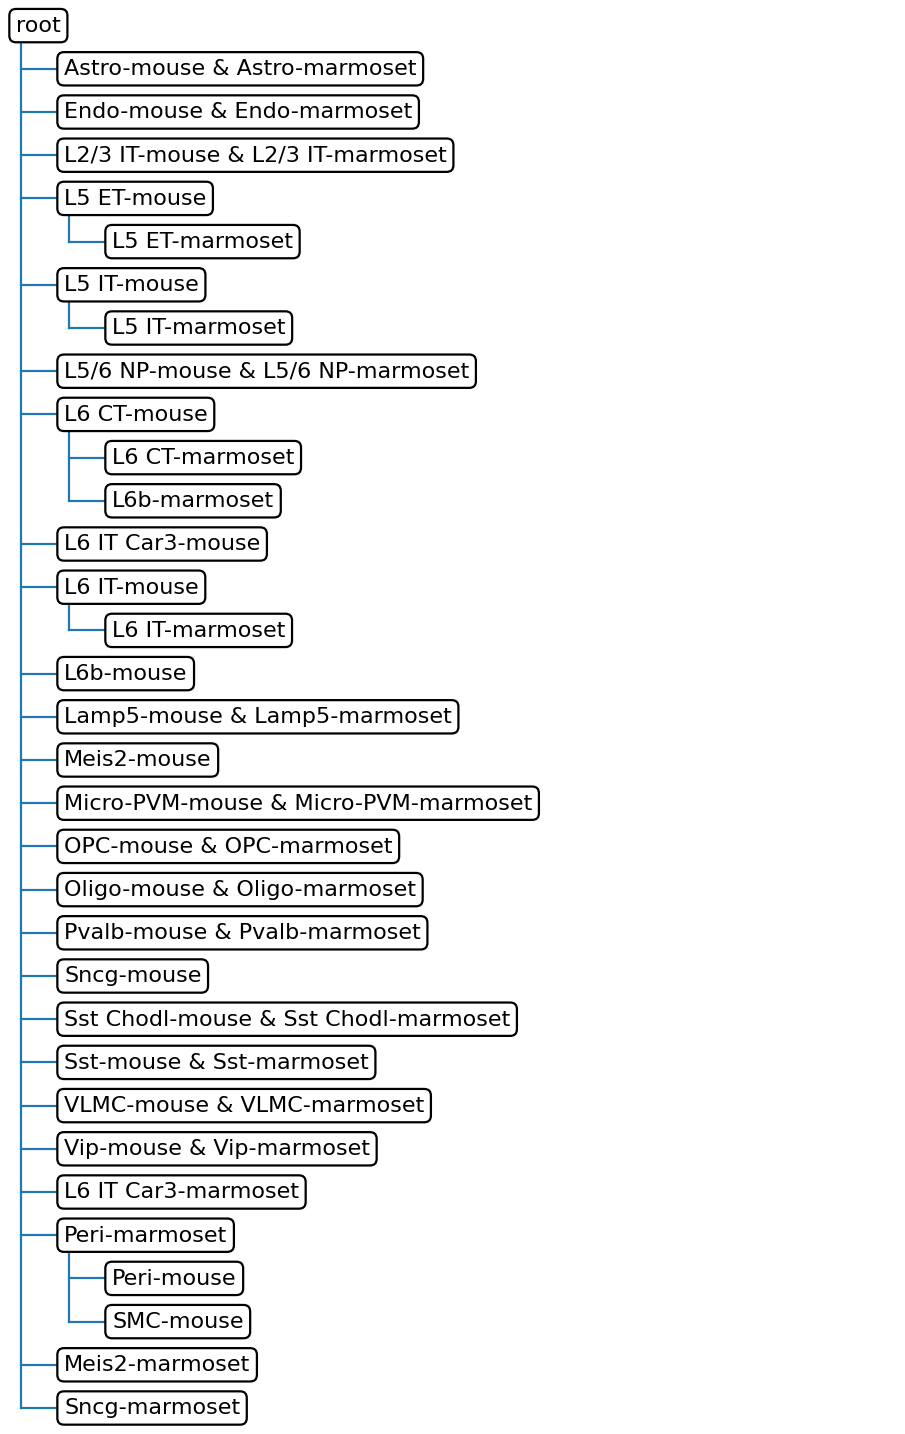


Adding dataset human to the tree

Updated tree:


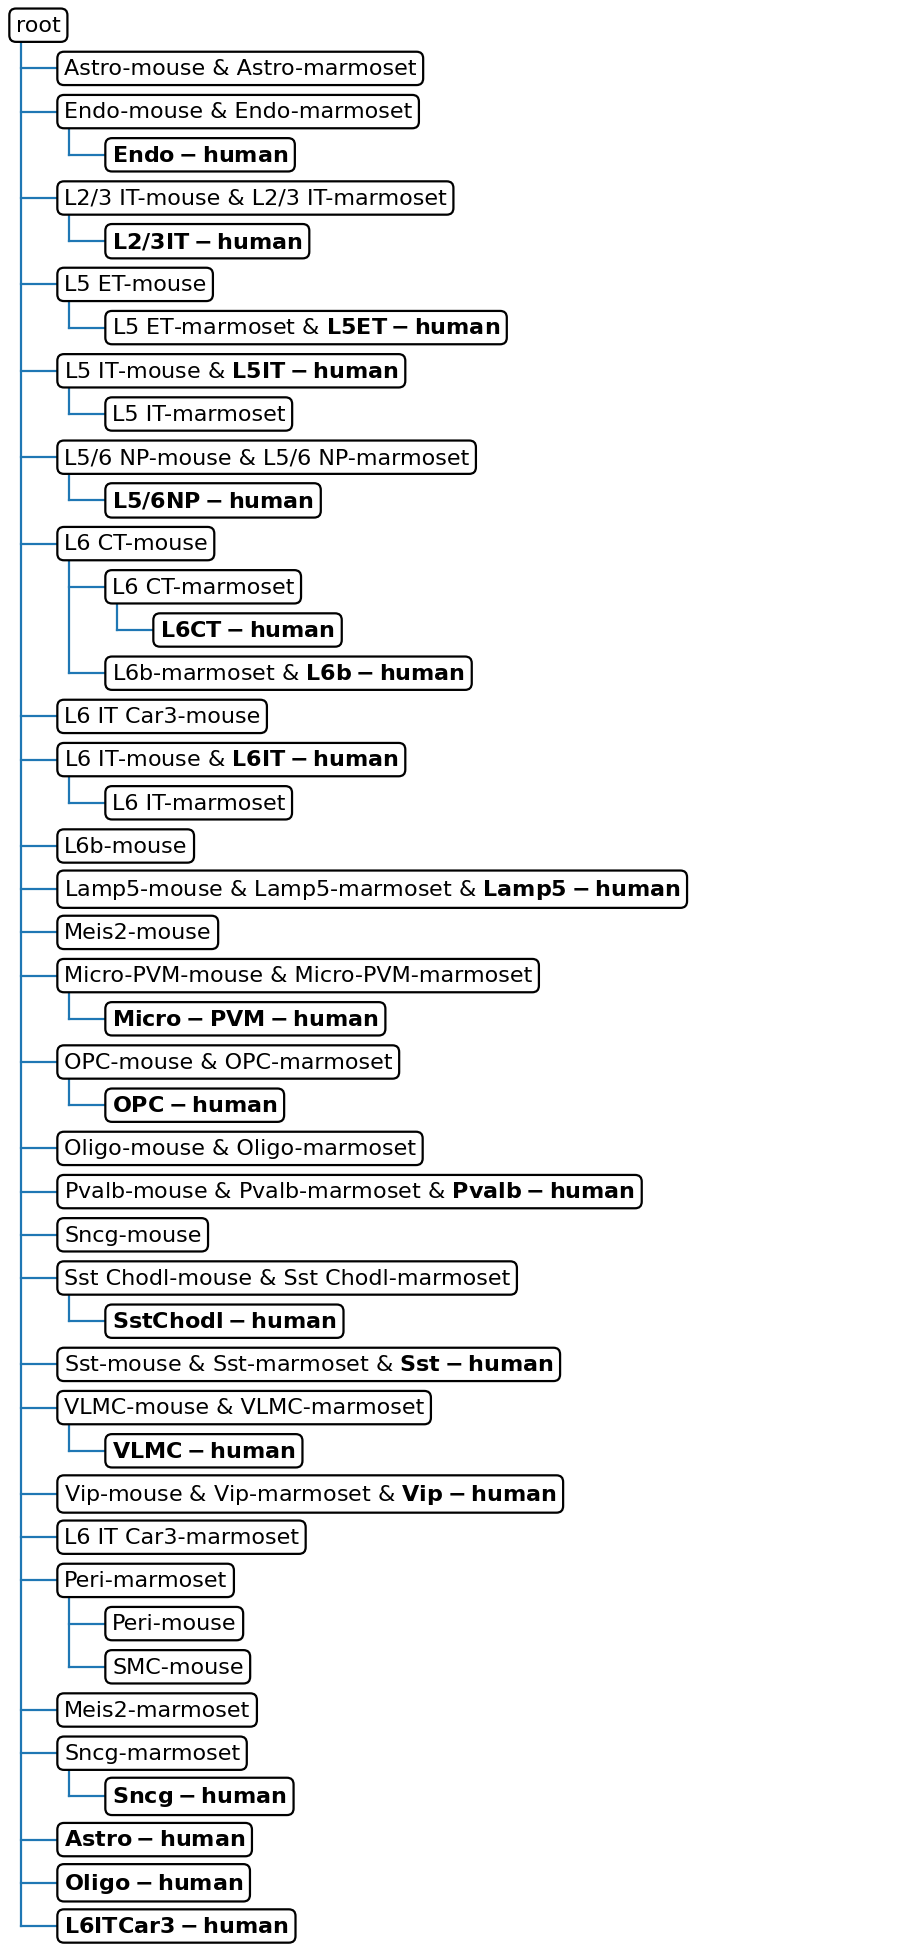

In [57]:
tree_full, mp_full = sca.classifiers.scHPL.learn_tree(data = full_latent, 
                batch_key = 'species',
                batch_added = ['mouse', 'marmoset'],
                batch_order = ['human'],
                cell_type_key='subclass_batch',
                retrain = False,
                tree = tree_ref,
                classifier = 'knn')